<a href="https://colab.research.google.com/github/JarekMaleszyk/data-science-project-sandbox/blob/main/clean_audible_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [20]:
%%bash
rm -rf /content/audible
wget -P "/content/audible/" "https://raw.githubusercontent.com/JarekMaleszyk/pandas-project-data/main/audible_raw.csv"

--2024-10-16 13:28:48--  https://raw.githubusercontent.com/JarekMaleszyk/pandas-project-data/main/audible_raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12069769 (12M) [text/plain]
Saving to: ‘/content/audible/audible_raw.csv’

     0K .......... .......... .......... .......... ..........  0% 2.38M 5s
    50K .......... .......... .......... .......... ..........  0% 16.4M 3s
   100K .......... .......... .......... .......... ..........  1% 5.94M 2s
   150K .......... .......... .......... .......... ..........  1% 21.7M 2s
   200K .......... .......... .......... .......... ..........  2% 33.7M 2s
   250K .......... .......... .......... .......... ..........  2% 8.03M 2s
   300K .......... .......... .......... .......... ..........  2% 37.4M 1s

In [21]:
RAW_FILE_PATH = '/content/audible/audible_raw.csv'

try:
  audible = pd.read_csv(RAW_FILE_PATH, header=0)
except FileNotFoundError as e:
  print(e)

In [22]:
audible.author = audible.author.str.replace('Writtenby:', '')
audible.author = audible.author.str.replace(r"([A-Z])", r" \1", regex=True).str.strip()
audible.author = audible.author.str.replace('\' ', '\'')
audible.author = audible.author.str.replace('\- ', '\-')
audible.narrator = audible.narrator.str.replace('Narratedby:', '')
audible.narrator = audible.narrator.str.replace(r"([A-Z])", r" \1", regex=True).str.strip()
audible.narrator = audible.narrator.str.replace('\' ', '\'')
audible.narrator = audible.narrator.str.replace('\- ', '\-')

In [23]:
audible.stars.replace('Not rated yet', np.nan, inplace=True)

<ipython-input-23-18ea99e802f7>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  audible.stars.replace('Not rated yet', np.nan, inplace=True)


In [24]:
audible['releaseyear'] = audible.releasedate.str[-2:].astype(int)
audible['releaseyear'] = audible['releaseyear'].apply(lambda x: 2000 + x if x < 50 else 1900 + x) #apply
audible['releasemonth'] = audible.releasedate.str[3:5].astype(int)
audible['releaseday'] = audible.releasedate.str[0:2].astype(int)

In [25]:
audible['releasedate'] = pd.to_datetime((audible.releaseyear*10000+audible.releasemonth*100+audible.releaseday).apply(str),format='%Y%m%d')

In [26]:
audible.drop(['releaseday', 'releasemonth', 'releaseyear'], axis=1, inplace=True)

In [27]:
audible.time = audible.time.str.replace("Less than 1 minute", "1 min").str.replace("Less than 1 min", "1 min")
audible.time = audible.time.str.replace("hrs", "hr")
audible.time = audible.time.str.replace("mins", "min").str.replace("minutes", "min").str.replace("minute", "min")
audible['timehours'] = audible.time.str.extract(r'(\d+) hr').fillna(0).astype(int)
audible['timemins'] = audible.time.str.extract(r'(\d+) min').fillna(0).astype(int)

In [28]:
audible['timemins'] = 60 * audible['timehours'] + audible['timemins']
audible.drop(['time', 'timehours'], axis=1, inplace=True)

In [29]:
audible['rating_stars'] = audible.stars.str.extract("^([\d.]+)").astype("float")
audible['n_ratings'] = audible.stars.str.extract("(\d+) rating").astype("float")

In [30]:
audible.drop(columns=['stars'], axis=1, inplace=True)

In [31]:
try:
  audible.price = audible.price.str.replace("Free", "0.0")
  audible.price = audible.price.str.replace(",", "").astype('float')
  audible.rating_stars = audible.rating_stars.astype('category')
except AttributeError as e:
  print(e)

In [32]:
audible["language"] = audible["language"].str.upper()

In [33]:
audible.duplicated().sum()
subset_cols = ["name", "author", "narrator", "timemins", "price"]
audible.duplicated(subset=subset_cols).sum()

70

In [34]:
audible[audible.duplicated(subset=subset_cols, keep=False)].sort_values(by="name")

,name,author,narrator,releasedate,language,price,timemins,rating_stars,n_ratings
63978,"""Das Böse ist des Menschen beste Kraft""",Christian Liederer,Thomas Krause,2021-12-14,GERMAN,233.0,144,NaN,NaN
63965,"""Das Böse ist des Menschen beste Kraft""",Christian Liederer,Thomas Krause,2021-12-23,GERMAN,233.0,144,NaN,NaN
24625,90 Minutes in Heaven,"Don Piper, Cecil Murphey",Don Piper,2015-09-25,ENGLISH,586.0,495,NaN,NaN
24116,90 Minutes in Heaven,"Don Piper, Cecil Murphey",Don Piper,2020-10-15,ENGLISH,586.0,495,NaN,NaN
16971,Adagio in Dm,Bill Brown,Bill Brown,2021-08-06,ENGLISH,456.0,78,NaN,NaN
...,...,...,...,...,...,...,...,...,...
18338,What I Talk About When I Talk About Running,Haruki Murakami,Ray Porter,2016-07-07,ENGLISH,398.0,263,4.5,193.0
38021,When Women Ruled the World,Kara Cooney,Kara Cooney,2018-11-30,ENGLISH,836.0,555,4.5,14.0
20260,When Women Ruled the World,Kara Cooney,Kara Cooney,2018-11-30,ENGLISH,836.0,555,4.5,13.0
22158,Wings of Fire,"A P J Abdul Kalam, Arun Tiwari",Girish Karnad,2020-04-01,ENGLISH,75.0,75,5.0,823.0


In [35]:
audible.drop_duplicates(subset=subset_cols, keep='last', inplace=True)

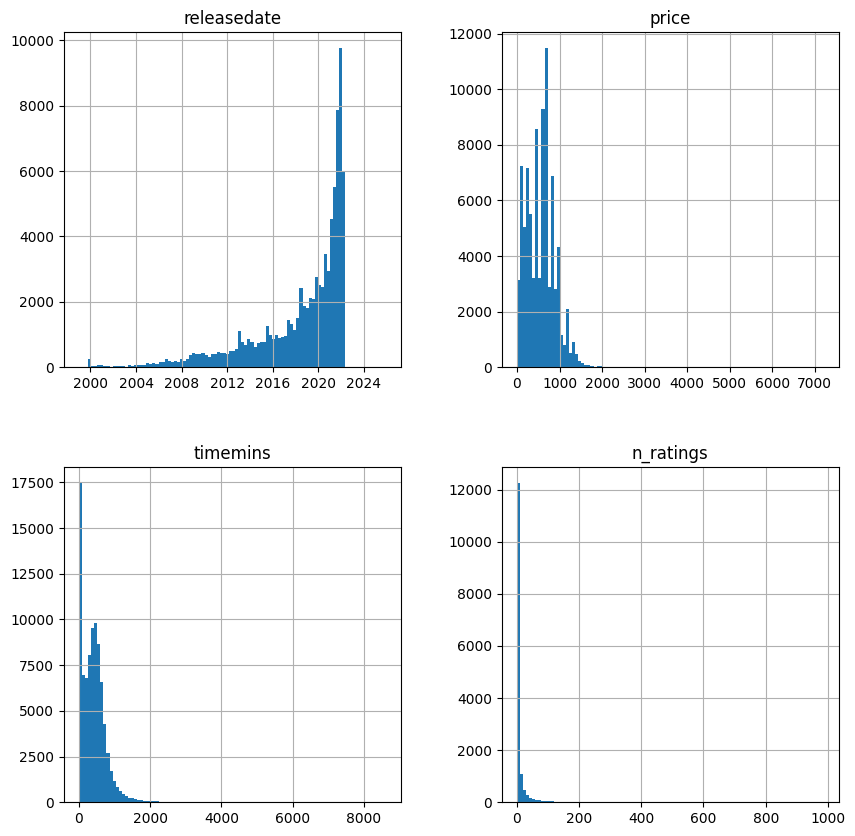

In [36]:
audible.hist(figsize=(10,10), bins=100 )
plt.show()